# ArXiv Semantic Graph – Project Demo

This notebook demonstrates the main steps of our pipeline:

1. Exploratory Data Analysis (EDA)
2. Embeddings (Universal Sentence Encoder)
3. HNSW index for fast nearest neighbours
4. Distance histogram and global threshold τ
5. Semantic graph construction
6. Graph clustering (Louvain communities)
7. Semantic recommendation demo


## Section 0 - Imports and paths

In [8]:
# ============================
# SECTION 0 — PROJECT SETUP
# ============================

from pathlib import Path
import sys
import glob
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

%matplotlib inline

# -----------------------------
# 0.1 — Resolve project paths
# -----------------------------
# Your repo structure:
# project/
#   ├─ src/
#   ├─ outputs/
#   ├─ notebooks/
#   └─ data/

NOTEBOOK_DIR = Path.cwd()
ROOT = NOTEBOOK_DIR.parent
SRC = ROOT / "src"

print("ROOT:", ROOT)
print("SRC:", SRC)

# -----------------------------
# 0.2 — Add src/ to PYTHONPATH
# -----------------------------
if str(SRC) not in sys.path:
    sys.path.insert(0, str(SRC))

print("\nPYTHONPATH updated. Current sys.path first entries:")
print("\n".join(sys.path[:3]))

# -----------------------------
# 0.3 — Project imports
# -----------------------------
from arxiv_semantic_graph import eda, embeddings, graph, graph_clustering, recommend

print("\n[OK] Project modules imported successfully.")

# -----------------------------
# 0.4 — Paths to data and outputs
# -----------------------------
DATA_PATH = ROOT / "data" / "arxiv-metadata-oai-snapshot.json"

OUTPUTS = ROOT / "outputs"
OUTPUTS.mkdir(exist_ok=True)

EMB_DIR = OUTPUTS / "embeddings"
if not EMB_DIR.exists():
    print(
        f"Embeddings directory not found at:\n{EMB_DIR}\n"
        "Run the embedding extraction pipeline first."
    )

# -----------------------------
# 0.5 — Locate embedding shards
# -----------------------------
emb_paths = sorted(EMB_DIR.glob("emb_*.npy"))
if not emb_paths:
    print(f"No embedding shards found in {EMB_DIR}")

print(f"\n[Info] Found {len(emb_paths)} embedding shards.")


ROOT: /home/zealot/DTU/Computational_Tools
SRC: /home/zealot/DTU/Computational_Tools/src

PYTHONPATH updated. Current sys.path first entries:
/home/zealot/DTU/Computational_Tools/src
/home/zealot/micromamba/envs/arxiv/lib/python311.zip
/home/zealot/micromamba/envs/arxiv/lib/python3.11

[OK] Project modules imported successfully.
Embeddings directory not found at:
/home/zealot/DTU/Computational_Tools/outputs/embeddings
Run the embedding extraction pipeline first.
No embedding shards found in /home/zealot/DTU/Computational_Tools/outputs/embeddings

[Info] Found 0 embedding shards.


## Section 1 - EDA

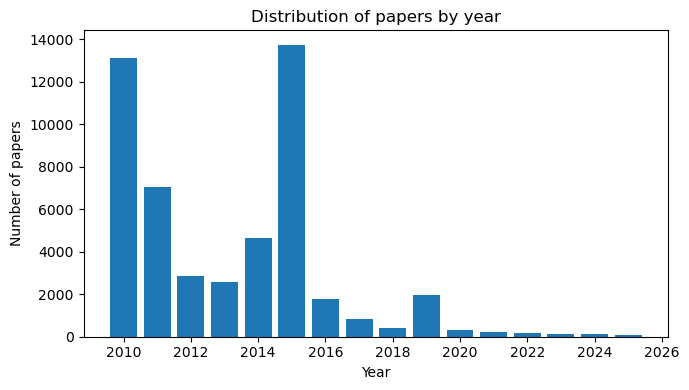

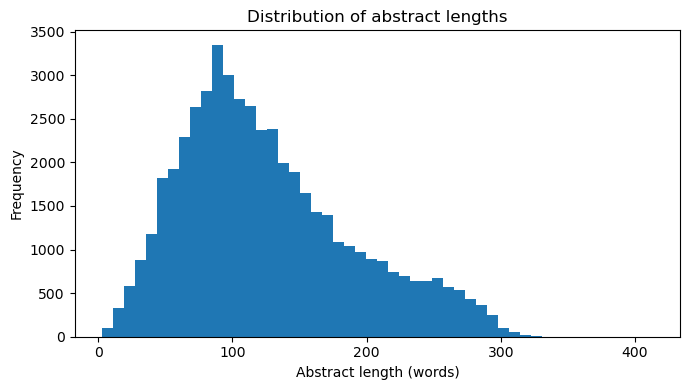

In [9]:
years, lengths = eda.load_eda_data(
    file_path=str(DATA_PATH),
    max_papers=50000,
    min_year=2010,
)

stats = eda.compute_eda_stats(years, lengths)

eda.plot_year_distribution(years, save_path=None, show=True)
eda.plot_length_distribution(lengths, save_path=None, show=True)

## Section 2 -Embeddings

In [10]:
import sys, tensorflow as tf
print(sys.executable)
print(tf.__version__)
print(tf.test.is_built_with_cuda())
print(tf.config.list_physical_devices("GPU"))


/home/zealot/micromamba/envs/arxiv/bin/python
2.15.0
True
[]


In [11]:
DATA_PATH = Path("../data/arxiv-metadata-oai-snapshot.json")
EMB_DIR = Path("../outputs/embeddings")
EMB_DIR.mkdir(exist_ok=True)

total_embedded = embeddings.run_embeddings(
    file_path=str(DATA_PATH),
    out_dir=str(EMB_DIR),
    batch_size=64,
    shard_size=25000,
    min_year=2024,
    min_words=200,
    use_gpu=True,           # ← ENABLE GPU
    vram_mib=4096,          # ← OPTIONAL: cap GPU memory
    force_recompute=False,
)

print("Total embedded:", total_embedded)


[CPU] Running without GPU (or no GPU detected)
[Embeddings] Reading from: ../data/arxiv-metadata-oai-snapshot.json
[Embeddings] Writing shards to: ../outputs/embeddings
[Embeddings] Filters: min_year=2024, min_words=200
[Embeddings] Batch size: 64, Shard size: 25000
[USE] Loading Universal Sentence Encoder...
[USE] Model loaded successfully
[Embeddings] Starting streaming and embedding...
[Shard 0] saved 25000 papers (total 25000)
[Shard 1] saved 25000 papers (total 50000)
[Shard 2] saved 25000 papers (total 75000)
[Shard 3] saved 25000 papers (total 100000)
[Shard 4] saved 25000 papers (total 125000)
[Shard 5] saved 23477 papers (total 148477)
[Embeddings] Complete! Total papers embedded: 148,477
[Embeddings] Verification: 6 shards, 148,477 vectors, dim=512
Total embedded: 148477


## Section 3 - HNSW

In [12]:
import glob
from arxiv_semantic_graph.graph import load_shapes, build_or_load_index


# 3.1 – Locate embedding shards
emb_paths = sorted(glob.glob(str(EMB_DIR / "emb_*.npy")))
assert emb_paths, f"No emb_*.npy files found in {EMB_DIR}"

N, D = load_shapes(emb_paths)
print(f"[Info] Total vectors: {N:,} | Dimension: {D}")

# 3.2 – Build or load HNSW index
index = build_or_load_index(
    emb_paths=emb_paths,
    dim=D,
    out_dir=OUTPUTS / "hnsw",
    efc=200,   # ef_construction (controls construction quality vs speed)
    M=16,      # maximum number of connections per node
    threads=8,
)

# 3.3 – Quick sanity check: k-NN query for a random paper
import random
import numpy as np

random_id = random.randint(0, N - 1)

# Load the actual embedding for that paper (better than using a dummy vector)
offset = 0
query_vec = None
for p in emb_paths:
    arr = np.load(p, mmap_mode="r")
    n = arr.shape[0]
    if random_id < offset + n:
        query_vec = arr[random_id - offset].astype("float32")
        break
    offset += n

assert query_vec is not None, "Could not locate embedding for random_id"

labels, dists = index.knn_query(query_vec.reshape(1, -1), k=5)

print(f"[HNSW] Index is ready.")
print(f"[HNSW] Example query for id {random_id} returns {labels.shape[1]} neighbors.")
print("Neighbor IDs:", labels[0])
print("Distances:   ", dists[0])


[Info] Total vectors: 148,477 | Dimension: 512
[HNSW] Building index…
  Added 25000/148477
  Added 50000/148477
  Added 75000/148477
  Added 100000/148477
  Added 125000/148477
  Added 148477/148477
[HNSW] Index is ready.
[HNSW] Example query for id 125051 returns 5 neighbors.
Neighbor IDs: [125051  36672  73765 122451  35031]
Distances:    [4.7683716e-07 2.2874051e-01 2.3242378e-01 2.4366951e-01 2.4623966e-01]


## Section 4 — Distance histogram & τ

In [13]:
# ---------------------------
# Section 3 — HNSW Index
# ---------------------------

from pathlib import Path
import glob
import numpy as np
from arxiv_semantic_graph.graph import load_shapes, build_or_load_index

print("[Section 3] Building or loading HNSW index...")

# 3.1 Locate embedding shards
EMB_DIR = ROOT / "outputs" / "embeddings"
emb_paths = sorted(glob.glob(str(EMB_DIR / "emb_*.npy")))
assert emb_paths, f"No embedding shards found in: {EMB_DIR}"

# 3.2 Get total vectors (N) and dimensionality (D)
N, D = load_shapes(emb_paths)
print(f"[Info] Total vectors = {N:,} | Dimension = {D}")

# 3.3 Build or load HNSW index
index = build_or_load_index(
    emb_paths=emb_paths,
    dim=D,
    out_dir=OUTPUTS / "hnsw",
    efc=200,
    M=16,
    threads=8,
)

print("[Section 3] HNSW index ready.")
print()


[Section 3] Building or loading HNSW index...
[Info] Total vectors = 148,477 | Dimension = 512
[HNSW] Building index…
  Added 25000/148477
  Added 50000/148477
  Added 75000/148477
  Added 100000/148477
  Added 125000/148477
  Added 148477/148477
[Section 3] HNSW index ready.



In [14]:
from arxiv_semantic_graph.graph import (
    compute_knn_distance_histogram,
    choose_tau_from_percentile,
)

print("[Section 4] Computing k-NN distance histogram...")

hist_result = compute_knn_distance_histogram(
    emb_dir=str(EMB_DIR),
    index=index,
    k=6,                      # 1 (self) + 5 neighbors
    out_dir=str(OUTPUTS / "eda")   # Stores plots & stats
)

hist_summary = hist_result["summary"]
hist_summary


[Section 4] Computing k-NN distance histogram...
[Histogram] Computing distance distributions with k=6…
  Processed 100000 vectors
[Histogram] Statistics: {
  "mean": 0.25393902758757275,
  "median": 0.25344790518283844,
  "std": 0.04456658847630024,
  "min": -1.1920928955078125e-07,
  "max": 0.5962079763412476
}


{'mean': 0.25393902758757275,
 'median': 0.25344790518283844,
 'std': 0.04456658847630024,
 'min': -1.1920928955078125e-07,
 'max': 0.5962079763412476}

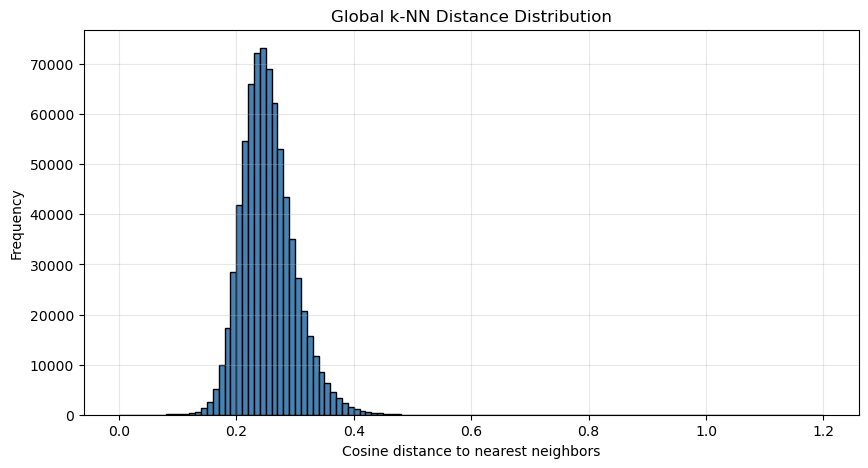

In [15]:
import matplotlib.pyplot as plt
import numpy as np

bins = hist_result["bins"]
global_hist = hist_result["global_hist"]
centers = 0.5 * (bins[1:] + bins[:-1])

plt.figure(figsize=(10, 5))
plt.bar(centers, global_hist, width=(bins[1] - bins[0]), color="steelblue", edgecolor="black")
plt.xlabel("Cosine distance to nearest neighbors")
plt.ylabel("Frequency")
plt.title("Global k-NN Distance Distribution")
plt.grid(alpha=0.3)
plt.show()


In [16]:
# Define candidate p_keep values
pkeep_candidates = [0.05, 0.10, 0.15, 0.20, 0.25]

tau_candidates = []

for p in pkeep_candidates:
    tau = choose_tau_from_percentile(
        hist_result["bins"],
        hist_result["global_hist"],
        pkeep=p
    )
    tau_candidates.append((p, tau))

tau_candidates


[Threshold] tau ≈ 0.1900 (≈5th percentile)
[Threshold] tau ≈ 0.2100 (≈10th percentile)
[Threshold] tau ≈ 0.2200 (≈15th percentile)
[Threshold] tau ≈ 0.2200 (≈20th percentile)
[Threshold] tau ≈ 0.2300 (≈25th percentile)


[(0.05, 0.19), (0.1, 0.21), (0.15, 0.22), (0.2, 0.22), (0.25, 0.23)]

In [17]:
import pandas as pd

tau_df = pd.DataFrame(
    [{"p_keep": p, "tau": tau} for p, tau in tau_candidates]
)

tau_file = OUTPUTS / "tau_candidates.csv"
tau_df.to_csv(tau_file, index=False)

print("Saved τ candidates to:", tau_file)

tau_df


Saved τ candidates to: /home/zealot/DTU/Computational_Tools/outputs/tau_candidates.csv


,p_keep,tau
0,0.05,0.19
1,0.10,0.21
2,0.15,0.22
3,0.20,0.22
4,0.25,0.23


## Section 5 — Graph construction

In [19]:
from arxiv_semantic_graph.graph import load_shapes, build_or_load_index
# Locate embedding shards (they must already exist)
emb_paths = sorted(glob.glob(str(EMB_DIR / "emb_*.npy")))
if not emb_paths:
    raise RuntimeError(
        f"No embedding shards found in {EMB_DIR}. "
        "Run the embedding extraction pipeline before this notebook."
    )

# Basic embedding stats
N, D = load_shapes(emb_paths)
print(f"[Setup] Found {len(emb_paths)} shards: {N:,} vectors, dim={D}")


[Setup] Found 6 shards: 148,477 vectors, dim=512


,p_keep,tau
0,0.05,0.19
1,0.10,0.21
2,0.15,0.22
3,0.20,0.22
4,0.25,0.23



[Info] Loaded tau candidates:
  pkeep=0.05 → tau=0.1900
  pkeep=0.10 → tau=0.2100
  pkeep=0.15 → tau=0.2200
  pkeep=0.20 → tau=0.2200
  pkeep=0.25 → tau=0.2300
[HNSW] Building index…
  Added 25000/148477
  Added 50000/148477
  Added 75000/148477
  Added 100000/148477
  Added 125000/148477
  Added 148477/148477

[Graph] Starting graph construction for each tau...

[Graph] Building graph for pkeep=0.05, tau≈0.1900
[Graph] Building edge list at tau=0.1900, k=50
  Processed nodes 0-20000
  Processed nodes 20000-25000
  Processed nodes 25000-45000
  Processed nodes 45000-50000
  Processed nodes 50000-70000
  Processed nodes 70000-75000
  Processed nodes 75000-95000
  Processed nodes 95000-100000
  Processed nodes 100000-120000
  Processed nodes 120000-125000
  Processed nodes 125000-145000
  Processed nodes 145000-148477
[Graph] Edge list written to /home/zealot/DTU/Computational_Tools/outputs/graphs/tau_0p190/edges_tau0.190.tsv
[Graph] Sample edges with titles -> /home/zealot/DTU/Computat

,pkeep,tau,nodes,edges,avg_degree,median_degree,isolated_nodes
0,0.05,0.19,148477,25347,0.341427,1.0,129176
1,0.10,0.21,148477,101172,1.362797,2.0,106718
2,0.15,0.22,148477,186608,2.513628,2.0,92680
3,0.25,0.23,148477,321803,4.334719,3.0,77704


[Graph] Saved summary to: /home/zealot/DTU/Computational_Tools/outputs/graphs/graph_summaries.csv


## Section 6 - Louvain communities

In [24]:
# ============================
# SECTION 6 — Louvain clustering
# ============================

from arxiv_semantic_graph import graph_clustering

# You already defined this earlier:
# GRAPH_DIR = OUTPUTS / "graphs"
LOUVAIN_DIR = OUTPUTS / "louvain"
LOUVAIN_DIR.mkdir(exist_ok=True)

print("GRAPH_DIR:", GRAPH_DIR)
print("LOUVAIN_DIR:", LOUVAIN_DIR)


def run_louvain_for_row(
    row,
    graphs_dir: Path = GRAPH_DIR,
    out_base: Path = LOUVAIN_DIR,
) -> dict:
    """
    Run Louvain clustering for a single row of `graphs_df`.

    Expected columns in `row`:
      - pkeep  (float)
      - tau    (float)
      - nodes  (int, number of nodes)
    """
    pkeep = float(row["pkeep"])
    tau = float(row["tau"])
    num_nodes = int(row["nodes"])

    # Use the SAME rounding + naming as in Section 5
    tau_rounded = round(tau, 3)
    tau_tag = f"tau_{tau_rounded:.3f}".replace(".", "p")   # e.g. 0.190 -> "tau_0p190"
    tau_str = f"{tau_rounded:.3f}"                         # e.g. "0.190"

    edge_path = graphs_dir / tau_tag / f"edges_tau{tau_str}.tsv"
    out_dir = out_base / tau_tag
    out_dir.mkdir(parents=True, exist_ok=True)

    print(f"\n[Louvain] Running for pkeep={pkeep:.3f}, tau≈{tau_rounded:.3f}")
    print(f"[Louvain] Loading edges from: {edge_path}")

    res = graph_clustering.run_louvain(
        edge_path=str(edge_path),
        num_nodes=num_nodes,
        out_dir=str(out_dir),
    )

    return {
        "pkeep": pkeep,
        "tau": tau_rounded,
        "modularity": res["modularity"],
        "num_communities": res["num_communities"],
        "edges_file": str(edge_path),
        "out_dir": str(out_dir),
    }


# -----------------------------
# 6.1 — Run Louvain for all graphs
# -----------------------------
louvain_results = [
    run_louvain_for_row(row)
    for _, row in graphs_df.iterrows()
]

louvain_df = pd.DataFrame(louvain_results)

print("\n[Louvain] Summary of results:")
display(louvain_df)


GRAPH_DIR: /home/zealot/DTU/Computational_Tools/outputs/graphs
LOUVAIN_DIR: /home/zealot/DTU/Computational_Tools/outputs/louvain

[Louvain] Running for pkeep=0.050, tau≈0.190
[Louvain] Loading edges from: /home/zealot/DTU/Computational_Tools/outputs/graphs/tau_0p190/edges_tau0.190.tsv
[Louvain] Loading edge list from /home/zealot/DTU/Computational_Tools/outputs/graphs/tau_0p190/edges_tau0.190.tsv (N=148477)
[Louvain] Modularity = 0.9343
[Louvain] Communities found = 133006
[Louvain] Partition saved to /home/zealot/DTU/Computational_Tools/outputs/louvain/tau_0p190/louvain_partition.tsv
[Louvain] Summary saved to /home/zealot/DTU/Computational_Tools/outputs/louvain/tau_0p190/louvain_summary.json

[Louvain] Running for pkeep=0.100, tau≈0.210
[Louvain] Loading edges from: /home/zealot/DTU/Computational_Tools/outputs/graphs/tau_0p210/edges_tau0.210.tsv
[Louvain] Loading edge list from /home/zealot/DTU/Computational_Tools/outputs/graphs/tau_0p210/edges_tau0.210.tsv (N=148477)
[Louvain] Modul

,pkeep,tau,modularity,num_communities,edges_file,out_dir
0,0.05,0.19,0.934340,133006,/home/zealot/DTU/Computational_Tools/outputs/g...,/home/zealot/DTU/Computational_Tools/outputs/l...
1,0.10,0.21,0.868229,110964,/home/zealot/DTU/Computational_Tools/outputs/g...,/home/zealot/DTU/Computational_Tools/outputs/l...
2,0.15,0.22,0.833143,96650,/home/zealot/DTU/Computational_Tools/outputs/g...,/home/zealot/DTU/Computational_Tools/outputs/l...
3,0.25,0.23,0.804924,81225,/home/zealot/DTU/Computational_Tools/outputs/g...,/home/zealot/DTU/Computational_Tools/outputs/l...


## Section 7 - Recomendation demo

In [25]:
# ============================
# SECTION 7 — Select best graph (tau) from Louvain
# ============================

import json

# 7.0 — Basic sanity checks
print("\n[Louvain] Available results:")
display(louvain_df)

# Drop rows with missing modularity or trivial graphs (0 or 1 community)
candidates = (
    louvain_df
    .dropna(subset=["modularity"])
    .query("num_communities > 1")
    .copy()
)

if candidates.empty:
    raise RuntimeError("[Louvain] No valid candidates to select from.")

# 7.1 — Select the graph with highest modularity
candidates = candidates.sort_values("modularity", ascending=False)
best_row = candidates.iloc[0]

BEST_PKEEP = float(best_row["pkeep"])
BEST_TAU = float(best_row["tau"])
BEST_MOD = float(best_row["modularity"])
BEST_COMM = int(best_row["num_communities"])

print("\n[Selection] Best graph according to modularity:")
print(f"  pkeep         : {BEST_PKEEP:.3f}")
print(f"  tau           : {BEST_TAU:.3f}")
print(f"  modularity    : {BEST_MOD:.4f}")
print(f"  communities   : {BEST_COMM}")

# 7.2 — Reconstruct folder names (must match Section 5 & 6)
tau_rounded = round(BEST_TAU, 3)
tau_tag = f"tau_{tau_rounded:.3f}".replace(".", "p")   # e.g. tau_0p190
tau_str = f"{tau_rounded:.3f}"                         # e.g. "0.190"

BEST_GRAPH_DIR = GRAPH_DIR / tau_tag
BEST_LOUVAIN_DIR = LOUVAIN_DIR / tau_tag
BEST_EDGES_PATH = BEST_GRAPH_DIR / f"edges_tau{tau_str}.tsv"

print("\n[Selection] Resolved paths:")
print(f"  Graph dir   : {BEST_GRAPH_DIR}")
print(f"  Louvain dir : {BEST_LOUVAIN_DIR}")
print(f"  Edges file  : {BEST_EDGES_PATH}")

# 7.3 — Save selection to a small JSON config for later use (e.g. in recommend.py)
best_graph_config = {
    "pkeep": BEST_PKEEP,
    "tau": tau_rounded,
    "modularity": BEST_MOD,
    "num_communities": BEST_COMM,
    "graph_dir": str(BEST_GRAPH_DIR),
    "louvain_dir": str(BEST_LOUVAIN_DIR),
    "edges_path": str(BEST_EDGES_PATH),
}

BEST_CONFIG_PATH = OUTPUTS / "best_graph_config.json"
with BEST_CONFIG_PATH.open("w", encoding="utf-8") as f:
    json.dump(best_graph_config, f, indent=2)

print(f"\n[Selection] Best graph configuration saved to: {BEST_CONFIG_PATH}")



[Louvain] Available results:


,pkeep,tau,modularity,num_communities,edges_file,out_dir
0,0.05,0.19,0.934340,133006,/home/zealot/DTU/Computational_Tools/outputs/g...,/home/zealot/DTU/Computational_Tools/outputs/l...
1,0.10,0.21,0.868229,110964,/home/zealot/DTU/Computational_Tools/outputs/g...,/home/zealot/DTU/Computational_Tools/outputs/l...
2,0.15,0.22,0.833143,96650,/home/zealot/DTU/Computational_Tools/outputs/g...,/home/zealot/DTU/Computational_Tools/outputs/l...
3,0.25,0.23,0.804924,81225,/home/zealot/DTU/Computational_Tools/outputs/g...,/home/zealot/DTU/Computational_Tools/outputs/l...



[Selection] Best graph according to modularity:
  pkeep         : 0.050
  tau           : 0.190
  modularity    : 0.9343
  communities   : 133006

[Selection] Resolved paths:
  Graph dir   : /home/zealot/DTU/Computational_Tools/outputs/graphs/tau_0p190
  Louvain dir : /home/zealot/DTU/Computational_Tools/outputs/louvain/tau_0p190
  Edges file  : /home/zealot/DTU/Computational_Tools/outputs/graphs/tau_0p190/edges_tau0.190.tsv

[Selection] Best graph configuration saved to: /home/zealot/DTU/Computational_Tools/outputs/best_graph_config.json


In [63]:
from arxiv_semantic_graph import recommend
import importlib
importlib.reload(recommend)


# Suppose:
#   EMB_DIR = OUTPUTS / "embeddings"
#   index   = your loaded hnswlib.Index

recs = recommend.recommend_random(
    emb_dir=str(EMB_DIR),
    index=index,
    k=5,
)

# Or for a specific id:
recs_id42 = recommend.recommend_for_id(
    emb_dir=str(EMB_DIR),
    index=index,
    paper_id=42,
    k=5,
)



 Random query paper
ID    : 105111
Year  : 2025
Title : Efficient Transformed Gaussian Process State-Space Models for Non-Stationary High-Dimensional Dynamical Systems

[Recommend] Loaded Louvain partition for 148,477 nodes.
[Recommendations]
- (id=104672, year=2025) ✓ significant
    On the Importance of Error Mitigation for Quantum Computation
    distance=0.1649

- (id=55233, year=2024) ✓ significant
    Photonics-integrated terahertz transmission lines
    distance=0.1852

- (id=67817, year=None) ✓ significant
    rational function fields over ultra-finite fields
    distance=0.1925

- (id=57998, year=None) ✓ significant
    Attention Pooling
    distance=0.1954

- (id=52844, year=2025) ✓ significant
    A Progressive Risk Formulation for Enhanced Deep Learning based Total
    distance=0.1979

[Recommend] Loaded Louvain partition for 148,477 nodes.
